In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics import tsaplots
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:

# import scipy
# from datetime import timedelta
# from pylab import rcParams


# from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
# #from fbprophet import Prophet
# !pip install pmdarima
# from pmdarima import auto_arima

# from statsmodels.tsa.tsatools import lagmat

# from tensorflow import keras

# from sklearn.linear_model import LinearRegression, RidgeCV
# from sklearn.ensemble import RandomForestRegressor, IsolationForest
# from sklearn.metrics import r2_score
# import re

In [4]:
df = pd.read_csv('https://tinyurl.com/tsa-df')
df['Date'] = pd.to_datetime(df['Date'])

In [5]:
def plot_ts(df, site, var, diff=False):
    if diff:
        var = var+'_diff'
    temp = df[df['Site'] == site].reset_index(drop=True)
    plt.figure(figsize=(20, 6))
    plt.plot(temp['Date'], temp[var])
    plt.title(f'{var} at {site}')
    plt.xticks(ticks=temp['Date'][temp['Date'].dt.is_month_start],
            labels=temp['Date'][temp['Date'].dt.is_month_start].dt.strftime('%m/%y'))

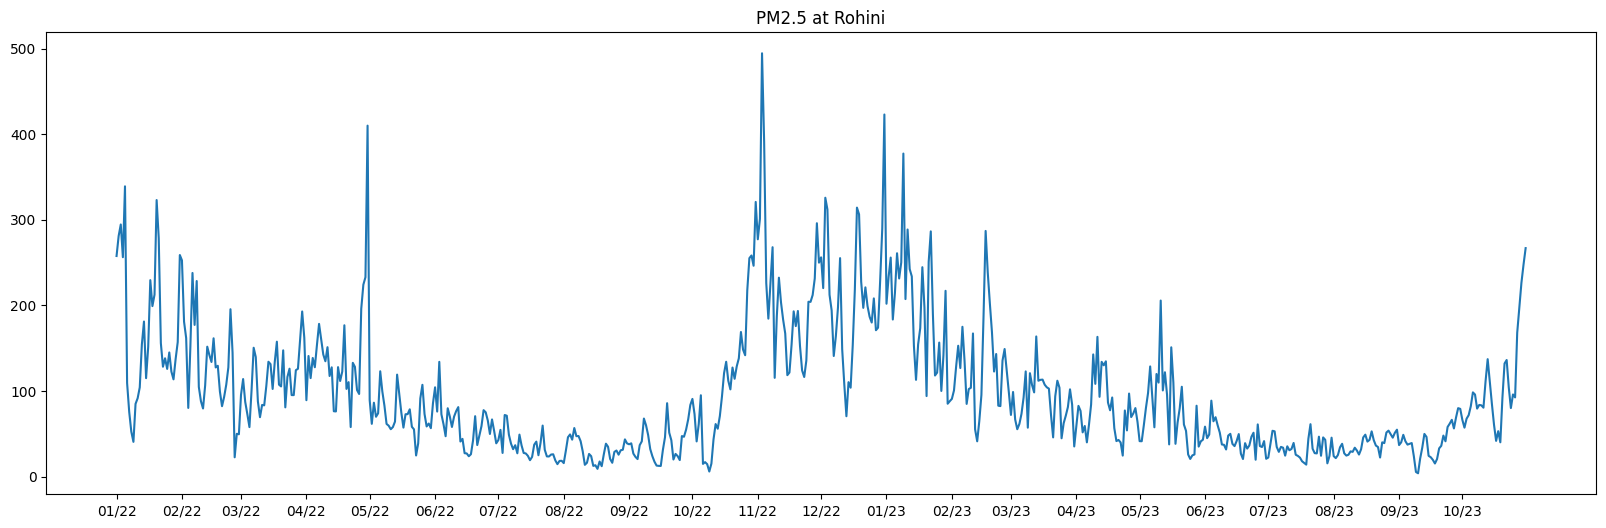

In [6]:
plot_ts(df, 'Rohini', 'PM2.5')

In [7]:
def test_stationarity(df,site, var, verbose=0):
    temp = df[df['Site'] == site].reset_index(drop=True)
    test = adfuller(temp[var])
    test_stat = round(test[0],3)
    pval = round(test[1],3)
    if pval < 0.05:
        if verbose == 1:
            print(f'{var} at {site} is stationary with p-value {pval} and test statistic {test_stat}')
        return 0, temp
    else:
        if verbose == 1:
            print(f'{var} at {site} is not stationary with p-value {pval} and test statistic {test_stat}')
            print('Differencing...')
        diff = temp[var].diff().dropna()
        test = adfuller(diff)
        test_stat = round(test[0],3)
        pval = round(test[1],3)
        if pval < 0.05:
            if verbose == 1:
                print(f'{var} at {site} is stationary with p-value {pval} and test statistic {test_stat}')
            temp_diff = temp[var].diff().dropna().to_frame(name=var+'_diff')
            temp = temp.join(temp_diff, how='left')
            return 1, temp
        else:
            if verbose == 1:
                print('Data is not stationary after differencing')      
            return

In [8]:
def plot_cf(df, var, type, lags = 30, diff=False):
    site = df['Site'].unique()[0]
    df = df.dropna().reset_index(drop=True)
    if diff:
        var = var+'_diff'
    if type == 'pacf':
        fig = tsaplots.plot_pacf(df[var], lags=lags)
        plt.title(f'PACF of {var} at {site}')
        fig.figure.set_size_inches(20, 6)
        return fig
    
    if type == 'acf':
        fig = tsaplots.plot_acf(df[var], lags=lags)
        plt.title(f'ACF of {var} at {site}')
        fig.figure.set_size_inches(20, 6)
        return fig

In [224]:
# for site in df['Site'].unique():
#     print(site, end=': ')
#     st = []
#     for var in ['PM2.5', 'PM10', 'NH3', 'SO2', 'AQI']:
#         st.append(test_stationarity(df,site, var)[0])
#     print(st)

In [10]:
def main(df, site, var, lags=30):
    diff, temp = test_stationarity(df,site, var, verbose=1)
    if diff:
        plot_ts(df, site, var)
        plot_ts(temp, site, var, diff=diff)
        plot_cf(temp, var, 'acf', lags=lags, diff=diff)
        plot_cf(temp, var, 'pacf', lags=lags, diff=diff)
    else:
        plot_ts(df, site, var)
        plot_cf(temp, var, 'acf', lags=lags, diff=diff)
        plot_cf(temp, var, 'pacf', lags=lags, diff=diff)

PM2.5 at Knowledge Park V is not stationary with p-value 0.276 and test statistic -2.024
Differencing...
PM2.5 at Knowledge Park V is stationary with p-value 0.0 and test statistic -13.388


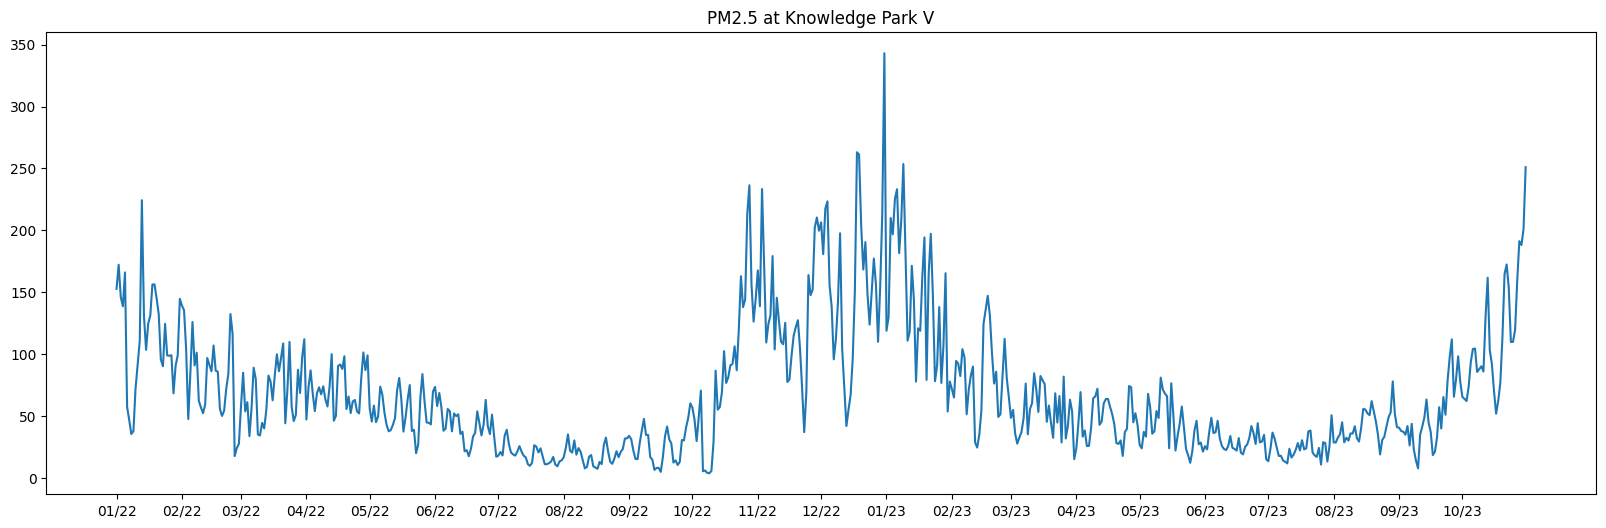

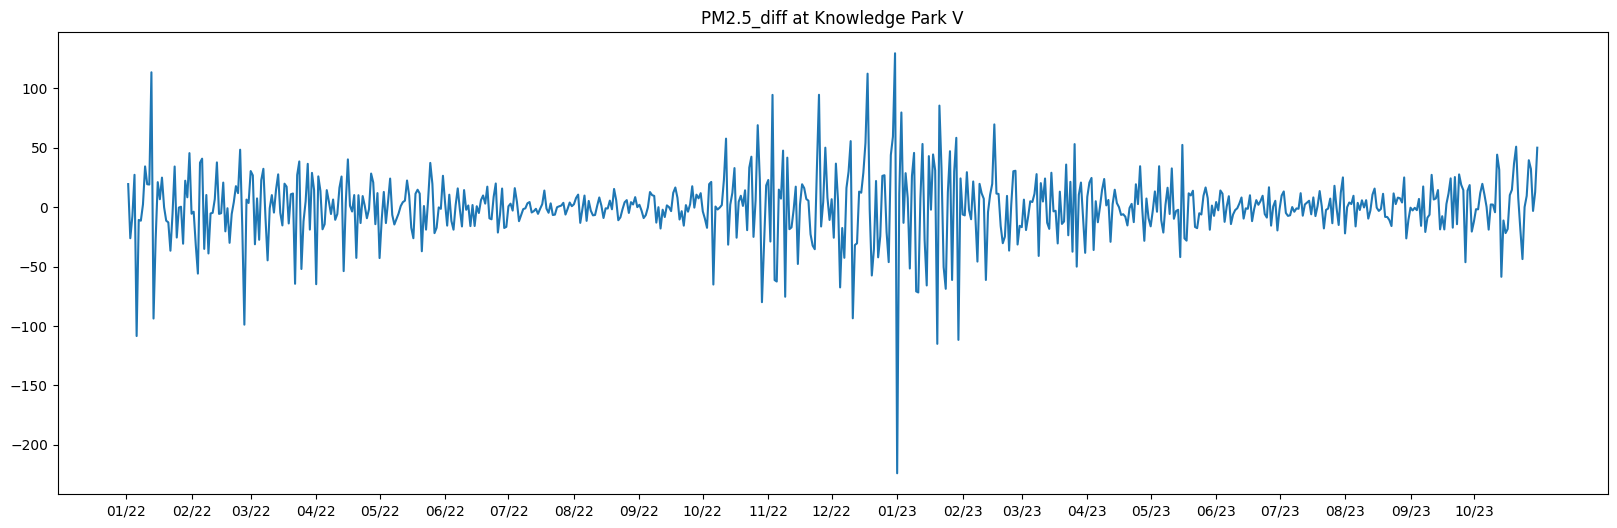

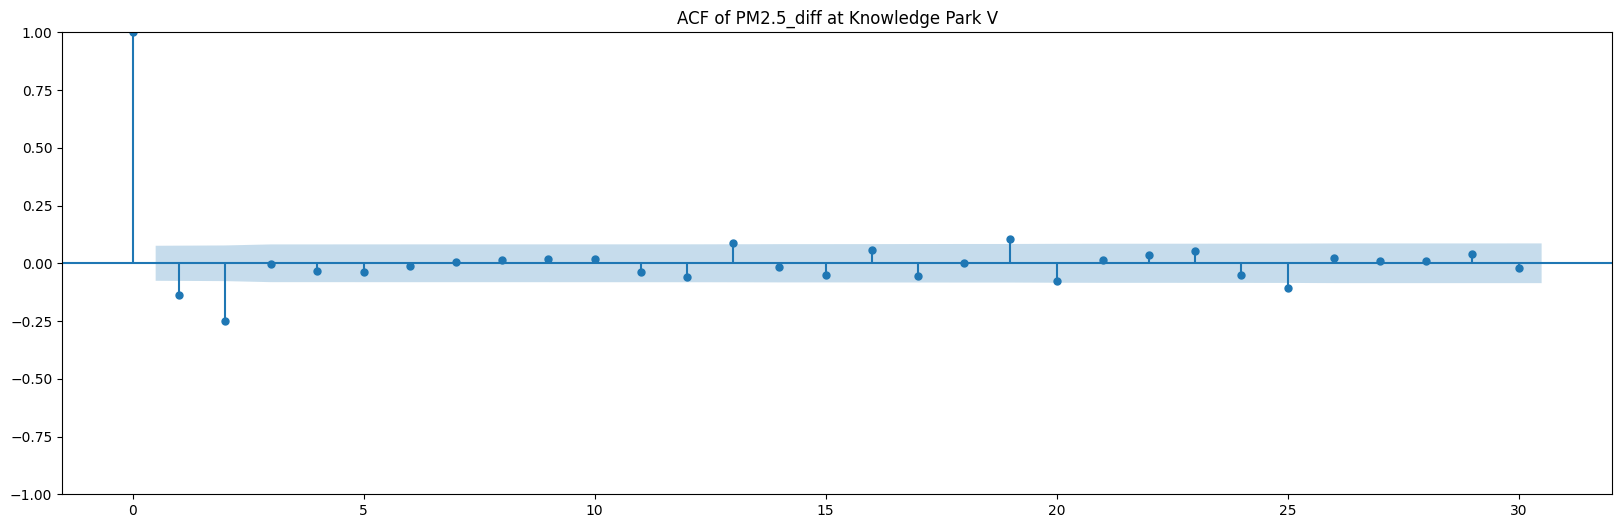

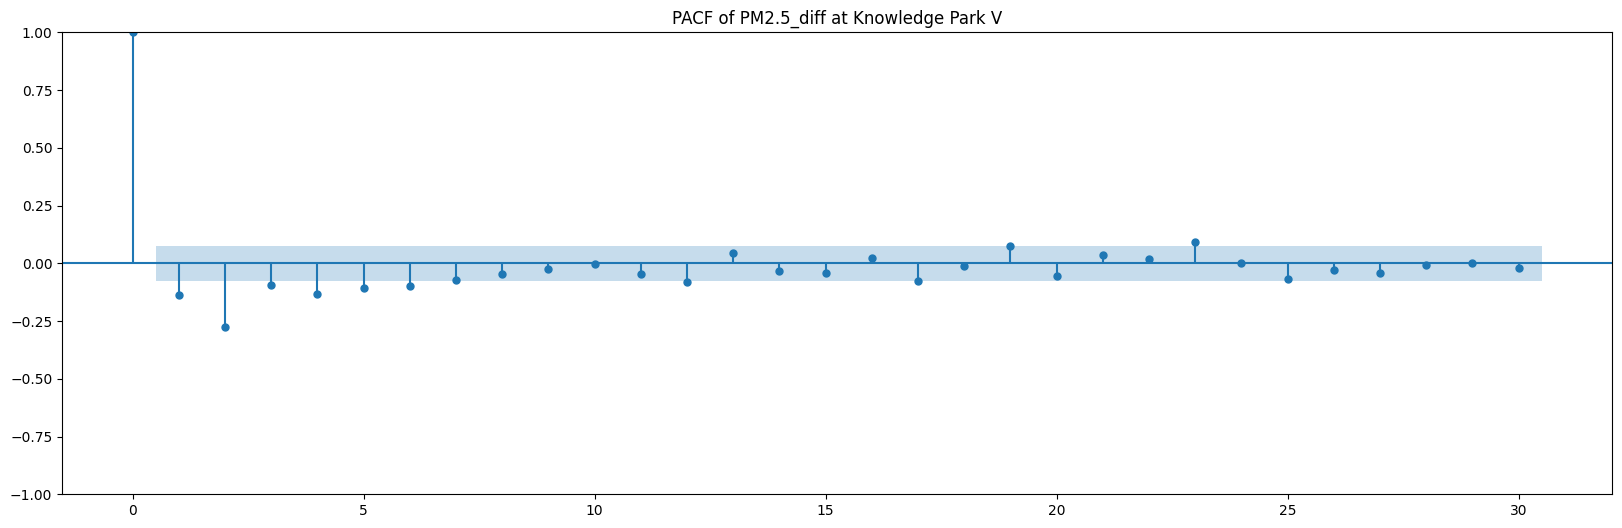

In [11]:
main(df, 'Knowledge Park V', 'PM2.5')

In [44]:
def get_lags(df, site, var, type, lags=30, alpha=0.05):
    diff, temp = test_stationarity(df,site, var, verbose=0)
    temp.dropna(inplace=True)
    if diff:
        var = var+'_diff'
    if type == 'acf':
        cf_vals, civals = sm.tsa.acf(temp[var], nlags=lags, alpha=alpha)
        civals = civals - cf_vals.reshape(-1,1)
        lag_vals = []
        cf_lag_vals = []
        for i in range(1,len(cf_vals)):
            if cf_vals[i] > civals[i][1] or cf_vals[i] < civals[i][0]:
                lag_vals.append(i) 
                cf_lag_vals.append(round(cf_vals[i],3))    
        return lag_vals , cf_lag_vals 

    if type == 'pacf':
        cf_vals, civals = sm.tsa.pacf(temp[var], nlags=lags, alpha=alpha)
        civals = civals - cf_vals.reshape(-1,1)
        lag_vals = []
        cf_lag_vals = []
        for i in range(1,len(cf_vals)):
            if cf_vals[i] > civals[i][1] or cf_vals[i] < civals[i][0]:
                lag_vals.append(i)
                cf_lag_vals.append(round(cf_vals[i],3))
        return lag_vals, cf_lag_vals

In [214]:
def is_decay(df, site, var, type, verbose=0):
    l,a = get_lags(df, site, var, type)
    if a[0] < 0.7:
        if verbose == 1:
            print(f'{type} cuts off')
        return None
    for i in range(1,len(l)):
        if abs(a[i]) < 0.7*abs(a[i-1]):
            if verbose == 1:
                print(f'{type} cuts off')
            return None
    if verbose == 1:
        print(f'{type} has exponential decay')
    return True

In [215]:
def get_lags_params(df, site, var, type):
    l,_ = get_lags(df, site, var, type)
    if len(l) < 5:
        return l
    else:
        return l[:5]

In [219]:
def make_decision(df, site, var, verbose=0):
    diff, _ = test_stationarity(df,site, var, verbose=0)

    if is_decay(df, site, var, 'pacf') == None and is_decay(df, site, var, 'acf') == None:
        p = [1]
        q = [1]
        diff = [diff]
        if verbose == 1:
            print('Both ACF and PACF cut off')
        return p,diff,q
    
    elif is_decay(df, site, var, 'pacf') and is_decay(df, site, var, 'acf') == None:
        p = [0]
        q = get_lags_params(df, site, var, 'acf')
        diff = [diff]
        if verbose == 1:
            print('ACF cuts off and PACF has exponential decay')
        return p,diff,q
    
    elif is_decay(df, site, var, 'pacf') == None and is_decay(df, site, var, 'acf'):
        p = get_lags_params(df, site, var, 'pacf')
        q = [0]
        diff = [diff]
        if verbose == 1:
            print('PACF cuts off and ACF has exponential decay')
        return p,diff,q 

In [221]:
# for i in df['Site'].unique():
#     for v in ['PM2.5']:
#         print(i)
#         test_stationarity(df, i, v, verbose=1)  
#         print(make_decision(df, i, v, verbose=1))
#         print()

PM2.5 at Rohini is stationary with p-value 0.012 and test statistic -3.367


([1, 2, 3, 5, 6], [0], [0])

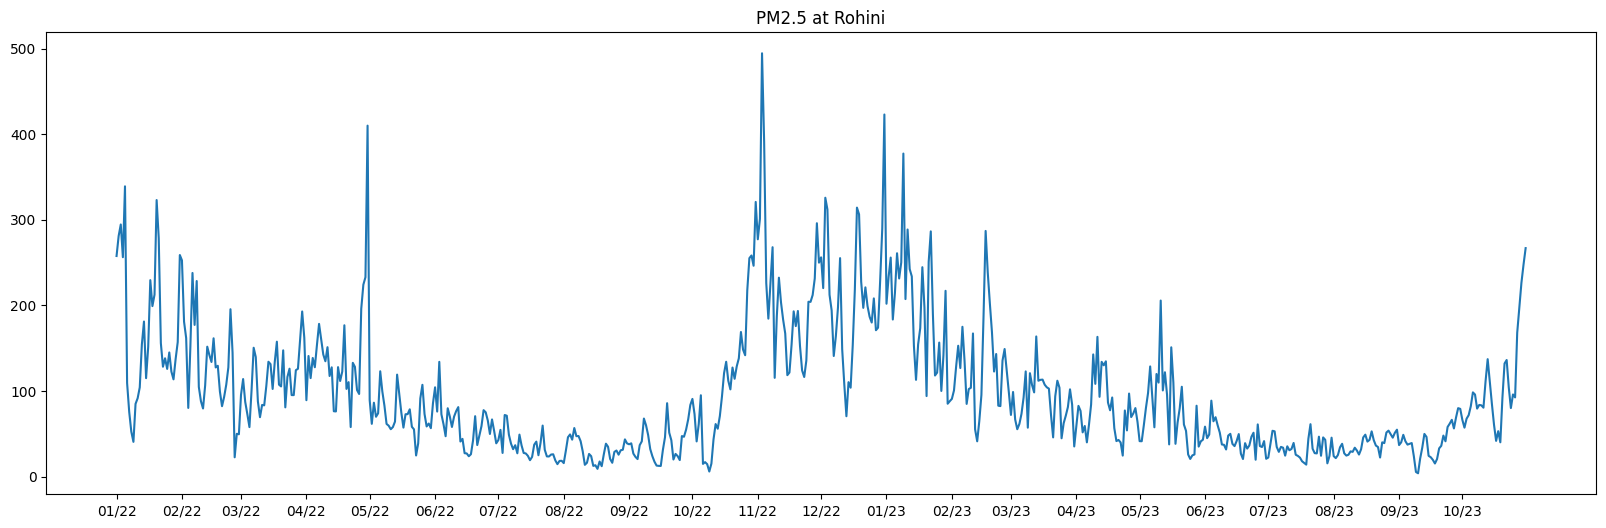

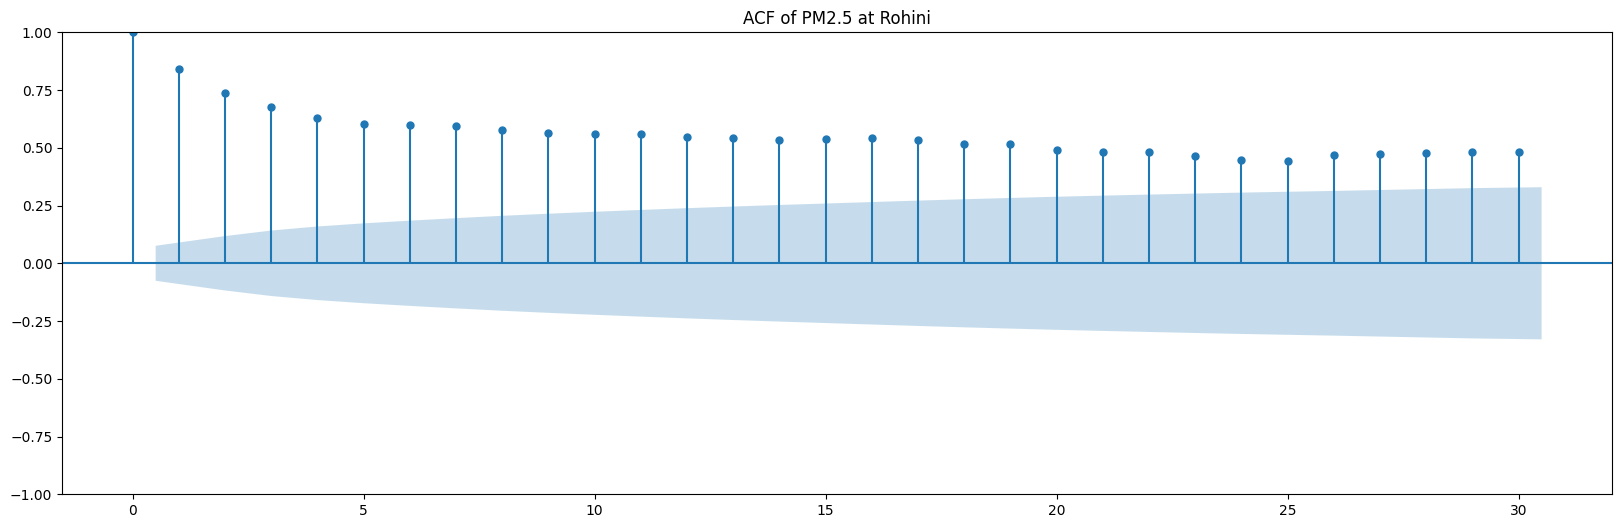

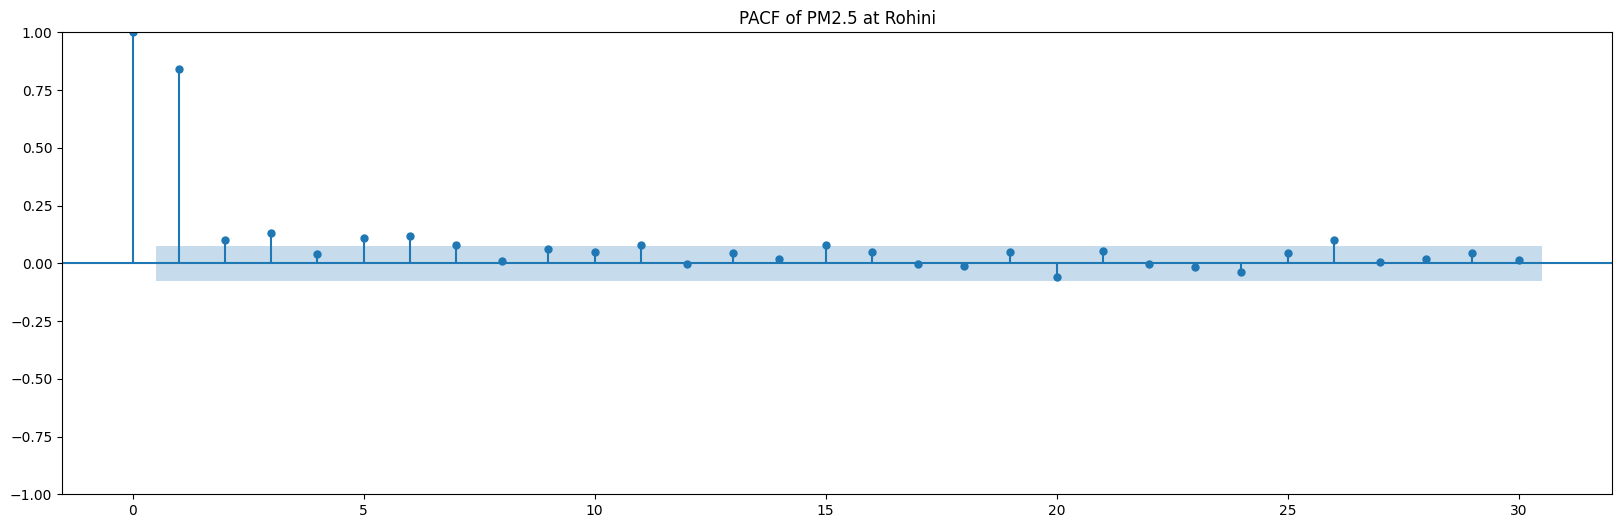

In [225]:
site = 'Rohini'
var = 'PM2.5'
main(df, site, var, lags=30)
make_decision(df, site, var)

In [230]:
site = 'Rohini'
var = 'PM2.5'
p_vals, d_vals, q_vals = make_decision(df, site, var, verbose=1)
print('Trying out the following combinations:')
print('p:',p_vals)
print('d:',d_vals)
print('q:',q_vals)
aic_vals = []
for p in p_vals:
    for q in q_vals:
        for d in d_vals:
            model = SARIMAX(df[var], order=(p,d,q))
            result = model.fit()
            aic_vals.append((p,d,q,result.aic))

aic_df = pd.DataFrame(aic_vals,columns=['p','d','q','aic'])
aic_df = aic_df.sort_values(by=['aic'])
model = SARIMAX(df[var],order=(int(aic_df.iloc[0]['p']),int(aic_df.iloc[0]['d']),int(aic_df.iloc[0]['q'])))
result = model.fit()
result.summary()

PACF cuts off and ACF has exponential decay
Trying out the following combinations:
p: [1, 2, 3, 5, 6]
d: [0]
q: [0]


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  PM2.5   No. Observations:                28098
Model:               SARIMAX(6, 0, 0)   Log Likelihood             -138526.428
Date:                Thu, 07 Nov 2024   AIC                         277066.857
Time:                        23:18:21   BIC                         277124.561
Sample:                             0   HQIC                        277085.430
                              - 28098                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7350      0.003    257.467      0.000       0.729       0.741
ar.L2         -0.0375      0.004     -8.567      0.000      -0.046      -0.029
ar.L3          0.1512      0.005     30.080      0.000       0.141       0.161
ar.L4        9.45e-05      0.006      0.017      0.987      -0.011       0.011
ar.L5          0.0290      0.005      5.327      0.000       0.018       0.040
ar.L6          0.0948      0.004     24.460      0.000       0.087       0.102
sigma2      1120.7511      3.971    282.204      0.000    1112.967    1128.535
===================================================================================
Ljung-Box (L1) (Q):                   7.52   Jarque-Bera (JB):            141253.50
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               1.22   Skew:                             0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""